# Cartoonize people in image

Before transfer, we should first import some necessary dependencies

In [1]:
import onnxruntime as rt
import numpy as np
import cv2
from matplotlib import pyplot as plt
import time

## Functions 

Resize images to fit model input and reduce computation time

In [2]:
def resize_crop(image):
    h, w, c = np.shape(image)
    if min(h, w) > 720:
        if h > w:
            h, w = int(720*h/w), 720
        else:
            h, w = 720, int(720*w/h)
    image = cv2.resize(image, (w, h), interpolation=cv2.INTER_AREA)
    h, w = (h//8)*8, (w//8)*8
    image = image[:h, :w, :]
    return image

Convert the image from raw to cartoon using the cartoon GAN model

In [3]:
def cartoonize(img, model):
    batch_image = img.astype(np.float32)/127.5 - 1
    batch_image = np.expand_dims(batch_image, axis=0)
    ort_inputs = {model.get_inputs()[0].name: batch_image}
    ort_outs = model.run(None, ort_inputs)
    img_out = ort_outs[0]
    output = (np.squeeze(img_out)+1)*127.5
    cartoon = np.clip(output, 0, 255).astype(np.uint8)
    return cartoon

Normalize image to fit deeplabv3 input

In [4]:
def normalize(img):
    MEAN = 255 * np.array([0.485, 0.456, 0.406])
    STD = 255 * np.array([0.229, 0.224, 0.225])
    img = img.transpose(-1, 0, 1)
    img = (img - MEAN[:, None, None]) / STD[:, None, None]
    output = np.array([img.astype('float32')])
    return output

Use deeplabv3 model to find person segmentation

In [5]:
def findmask_deeplabv3(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_image = normalize(image)
    
    ort_inputs = {model.get_inputs()[0].name: input_image}
    ort_outs = model.run(None, ort_inputs)
    
    output = ort_outs[0][0]
    person_class_mask = (output.argmax(axis=0) == 15).astype('uint8')

    mask1 = person_class_mask * 255
    mask2 = (255-mask1)
    return mask1,mask2


Use mask-rcnn model to find person segmentation

In [6]:
def findmask_mask_rcnn(image, model, threshold=0.5):
    image = image.transpose(-1, 0, 1)
    image = image/255
    input_image = np.array([image]).astype('float32')
    
    ort_inputs = {model.get_inputs()[0].name: input_image}
    ort_outs = model.run(None, ort_inputs)
    
    masks = (ort_outs[3]>0.5).squeeze()
    scores = ort_outs[2]
    
    valid_num = sum(map(lambda x : x > threshold, scores))
    if valid_num == 1 and len(scores) == 1:
        person_mask = masks.astype(np.uint8)
    elif valid_num > 0:
        person_mask = sum(masks[i] for i in range(len(masks)) if scores[i] > threshold).astype(np.uint8)
    else:
        person_mask = np.zeros(image.shape[:2], dtype='uint8')
    
    ret, mask1 = cv2.threshold(person_mask, 0, 255, cv2.THRESH_BINARY)
    mask2 = (255-mask1)
    return mask1,mask2

Set a timer to record how long the model computation takes

In [7]:
def time_spend(func):
    def inner(*args, **kwargs):
        begin = time.time()        
        value = func(*args, **kwargs)
        end = time.time()
        print(f'Total time taken is {end - begin} sec')
        return value
    return inner

Input the original image's path and use models to convert the image into a picture with cartoonize person

In [8]:
@time_spend
def get_output(img_path, func, deeplab, cartoon):      
    img = cv2.imread(img_path)
    img = resize_crop(img)
    
    mask1,mask2 = func(img, deeplab)

    cartoon_img = cartoonize(img, cartoon)
    
    person = cv2.bitwise_and(cartoon_img, cartoon_img, mask=mask1)
    background = cv2.bitwise_and(img, img, mask=mask2)
    output = person + background
    
    return output

## Transfer process

First, we need to load both deeplabv3 and mask-rcnn person segmentation models, and load the cartoonize GAN model.

We use the CPU here to execute the model.

Then, we need to define the input image's path.

In [9]:
deeplab = rt.InferenceSession('deeplabv3.onnx',providers=['CPUExecutionProvider'])
mask_rcnn = rt.InferenceSession('person_classifier.onnx',providers=['CPUExecutionProvider'])
cartoon = rt.InferenceSession('cartoonize.onnx',providers=['CPUExecutionProvider'])

path = 'test.jpg'

In this block, we use deeplabv3 model with mobilenet backbone to cartoonize people in the photo and record the time spent.

In [10]:
print('With deeplabv3 model :')
output_deep = get_output(path, findmask_deeplabv3, deeplab, cartoon)

With deeplabv3 model :
Total time taken is 1.6349945068359375 sec


In this block, we use mask-rcnn model with ResNet50 backbone to cartoonize people in the photo and record the time spent.

In [11]:
print('With mask-rcnn model :')
output_mask = get_output(path, findmask_mask_rcnn, mask_rcnn, cartoon)

With mask-rcnn model :
Total time taken is 3.5409951210021973 sec


Obviously, the deeplab model with a smaller backbone execute faster than mask-rcnn with a larger backbone.

Then we can plot the results of both models, both are good, considering the time spent, if the application is only for segmentation use, the deeplab model with mobilenet backbone is quite well.

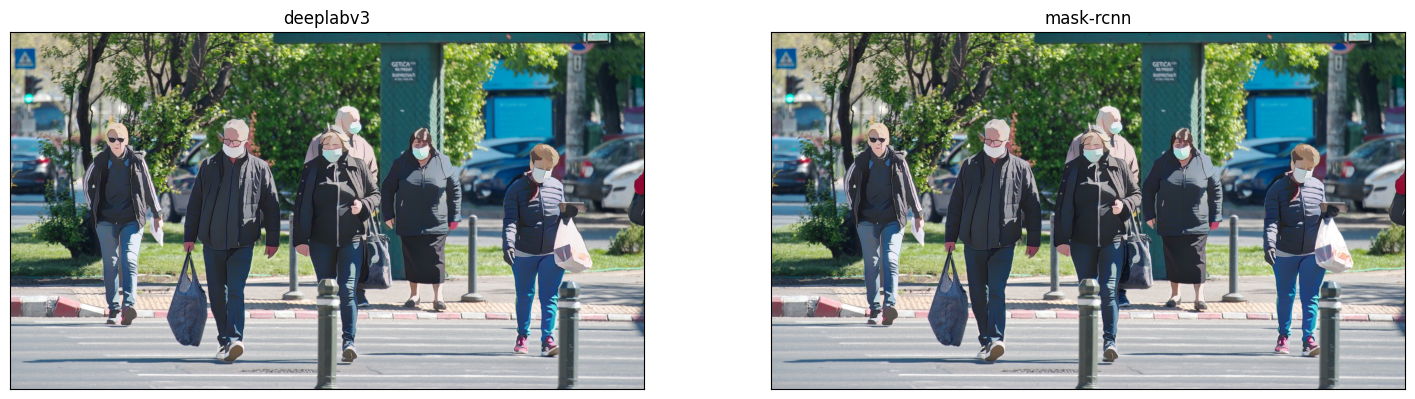

In [12]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(output_deep, cv2.COLOR_BGR2RGB))
plt.title('deeplabv3')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(output_mask, cv2.COLOR_BGR2RGB))
plt.title('mask-rcnn')
plt.xticks([])
plt.yticks([])
plt.show()

## Self cartoonize cam 

If you have an environment with onnxruntime-gpu and camera set up, you can try running this block and you'll get a self-cartoonizing camera.

You can also run it with the CPU, but it will be extremely slow.

If you want to quit, you can press the "q" key to quit.

In [13]:
deeplab = rt.InferenceSession('deeplabv3.onnx',providers=['CUDAExecutionProvider'])
cartoon = rt.InferenceSession('cartoonize.onnx',providers=['CUDAExecutionProvider'])

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("can't open camera")
    exit()
    
while(True):
    ret, frame = cap.read()
    
    if not ret:
        print("can't receive frame")
        break

    img = resize_crop(frame)
    
    mask1,mask2 = findmask_deeplabv3(img, deeplab)

    cartoon_img = cartoonize(img, cartoon)

    person = cv2.bitwise_and(cartoon_img, cartoon_img, mask=mask1)
    background = cv2.bitwise_and(img, img, mask=mask2)
    output = person + background

    cv2.imshow('cartoonize', output)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()